In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization,Activation
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest')

In [27]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')

Found 19674 images belonging to 2 classes.


In [30]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', 
                                                   batch_size=32, 
                                                   target_size=(120,120), 
                                                   class_mode='categorical',
                                                   shuffle=False, 
                                                   seed = 42, 
                                                   color_mode = 'rgb')

Found 2158 images belonging to 2 classes.


In [31]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')

Found 2162 images belonging to 2 classes.


In [9]:
x, y = next(train_generator)
print(f"Shape of batch (X): {x.shape}")
print(f"Shape of labels (Y): {y.shape}")


Shape of batch (X): (32, 120, 120, 3)
Shape of labels (Y): (32, 2)


In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.optimizers import Adam

In [20]:
xception = Xception(include_top = False,weights= "imagenet",input_shape=(120,120,3),pooling="avg",classes=2)

In [21]:
for layer in xception.layers:
    layer.trainable = False

In [22]:
model_0 = Sequential()
model_0.add(xception)
model_0.add(Flatten())
model_0.add(Dropout(0.3))
model_0.add(Dense(2,activation="softmax"))

model_0.build((None, 120,120, 3))
model_0.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,865,578 (79.60 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [23]:
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

#define checkpoint
checkpoint = ModelCheckpoint('model_xception.keras', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=6,
                          mode='auto',
                          verbose=1)

In [24]:
history = model_0.fit(train_generator,
                    batch_size=32,
                    steps_per_epoch=60,
                    epochs=10,
                    validation_data=valid_generator,
                    callbacks=[checkpoint,earlystop]
                   )

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - AUC: 0.5753 - accuracy: 0.5628 - loss: 0.7681
Epoch 1: val_accuracy improved from -inf to 0.66327, saving model to model_xception.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 60s 909ms/step - AUC: 0.5761 - accuracy: 0.5633 - loss: 0.7673 - val_AUC: 0.7361 - val_accuracy: 0.6633 - val_loss: 0.6018
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - AUC: 0.7092 - accuracy: 0.6561 - loss: 0.6447
Epoch 2: val_accuracy improved from 0.66327 to 0.73358, saving model to model_xception.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 844ms/step - AUC: 0.7094 - accuracy: 0.6563 - loss: 0.6444 - val_AUC: 0.8150 - val_accuracy: 0.7336 - val_loss: 0.5329
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - AUC: 0.8065 - accuracy: 0.7306 - loss: 0.5378
Epoch 3: val_accuracy improved from 0.73358 to 0.77336, saving model to model_xception.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 786ms/step - AUC: 0.8065 - accuracy: 0.7306 - loss: 0.5377 - val_AUC: 0.8618 - val_accuracy: 

In [25]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

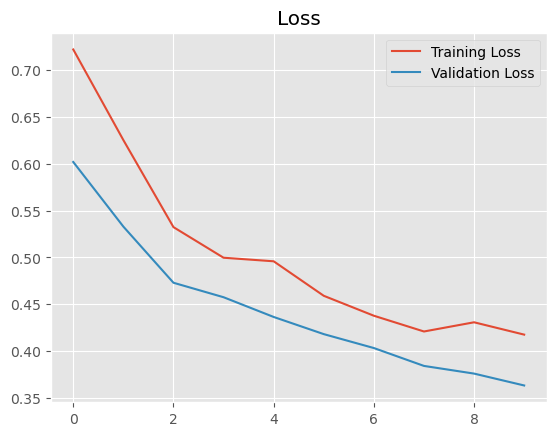

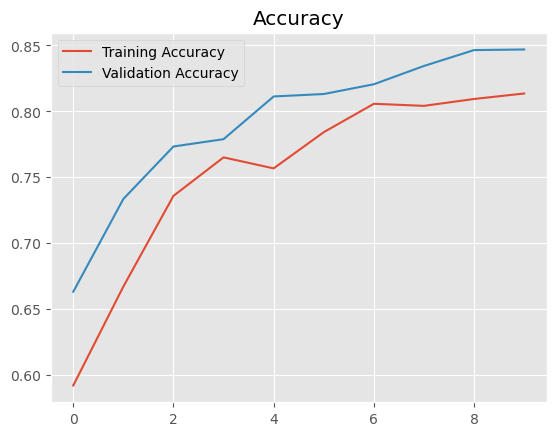

In [26]:
plot_metrics(history) 

In [32]:
xception = Xception(include_top=False, weights="imagenet", input_shape=(120,120, 3), pooling="avg")

# Freeze all layers initially
for layer in xception.layers:
    layer.trainable = False
# Unfreeze all layers starting from block 14
# Block 14 starts with the layer named "block14_sepconv1"
for layer in xception.layers:
    if layer.name.startswith("block14"):
        layer.trainable = True

for layer in xception.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Create a new Sequential model
model_0 = Sequential()
model_0.add(xception)
model_0.add(Flatten())
model_0.add(Dropout(0.3))
model_0.add(Dense(2, activation="softmax"))  # For binary classification

model_0.build((None,120,120,3))
# Print the model summary
model_0.summary()

input_layer_8: Trainable = False
block1_conv1: Trainable = False
block1_conv1_bn: Trainable = False
block1_conv1_act: Trainable = False
block1_conv2: Trainable = False
block1_conv2_bn: Trainable = False
block1_conv2_act: Trainable = False
block2_sepconv1: Trainable = False
block2_sepconv1_bn: Trainable = False
block2_sepconv2_act: Trainable = False
block2_sepconv2: Trainable = False
block2_sepconv2_bn: Trainable = False
conv2d_16: Trainable = False
block2_pool: Trainable = False
batch_normalization_16: Trainable = False
add_48: Trainable = False
block3_sepconv1_act: Trainable = False
block3_sepconv1: Trainable = False
block3_sepconv1_bn: Trainable = False
block3_sepconv2_act: Trainable = False
block3_sepconv2: Trainable = False
block3_sepconv2_bn: Trainable = False
conv2d_17: Trainable = False
block3_pool: Trainable = False
batch_normalization_17: Trainable = False
add_49: Trainable = False
block4_sepconv1_act: Trainable = False
block4_sepconv1: Trainable = False
block4_sepconv1_bn: Tr

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,865,578 (79.60 MB)

 Trainable params: 4,752,898 (18.13 MB)

 Non-trainable params: 16,112,680 (61.46 MB)

In [33]:
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

In [34]:
history = model_0.fit(train_generator,
                    batch_size=32,
                    steps_per_epoch=60,
                    epochs=10,
                    validation_data=valid_generator,
                    callbacks=[checkpoint,earlystop]
                   )

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - AUC: 0.8234 - accuracy: 0.7507 - loss: 0.5287
Epoch 1: val_accuracy improved from 0.84690 to 0.87280, saving model to model_xception.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 60s 927ms/step - AUC: 0.8244 - accuracy: 0.7516 - loss: 0.5274 - val_AUC: 0.9467 - val_accuracy: 0.8728 - val_loss: 0.2975
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - AUC: 0.9500 - accuracy: 0.8889 - loss: 0.3043
Epoch 2: val_accuracy improved from 0.87280 to 0.90981, saving model to model_xception.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 906ms/step - AUC: 0.9501 - accuracy: 0.8889 - loss: 0.3040 - val_AUC: 0.9671 - val_accuracy: 0.9098 - val_loss: 0.2327
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - AUC: 0.9667 - accuracy: 0.9067 - loss: 0.2429
Epoch 3: val_accuracy improved from 0.90981 to 0.92877, saving model to model_xception.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 906ms/step - AUC: 0.9668 - accuracy: 0.9069 - loss: 0.2426 - val_AUC: 0.9792 - val_accurac

In [35]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

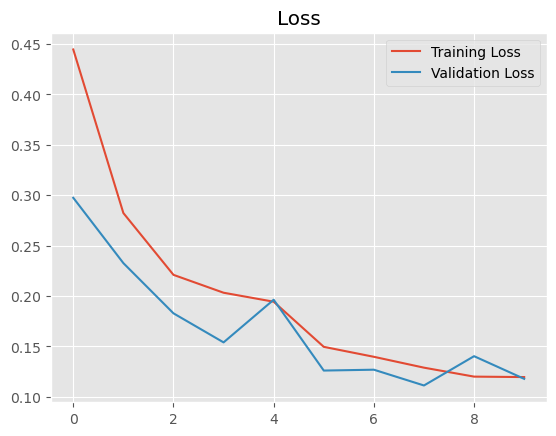

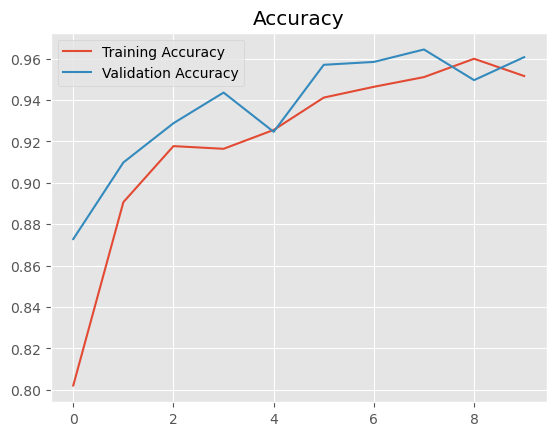

In [36]:
plot_metrics(history) 

In [23]:
from tensorflow.keras.models import Model, load_model
model_1=load_model("model_xception.keras")
model_1.metrics_names

['loss', 'compile_metrics']

In [ ]:
metrics = model_1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
auc = metrics[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}')

C:\Users\abhi2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/68 ━━━━━━━━━━━━━━━━━━━━ 14s 384ms/step - AUC: 0.9963 - accuracy: 0.9697 - loss: 0.0975

In [21]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.10416600853204727
Test Accuracy = 0.9657089710235596


In [22]:
predicted_probabilities = model_1.predict(test_generator)[:, 1]

# Set a custom threshold
threshold = 0.5  # Change this value to experiment
adjusted_predictions = (predicted_probabilities >= threshold).astype(int)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_generator.classes, adjusted_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, adjusted_predictions))

68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 377ms/step
Confusion Matrix:
 [[1026   53]
 [  33 1046]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1079
           1       0.95      0.97      0.96      1079

    accuracy                           0.96      2158
   macro avg       0.96      0.96      0.96      2158
weighted avg       0.96      0.96      0.96      2158

